In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from datetime import date
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import svm
from xgboost import XGBClassifier
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_plotly
import plotly.offline as py

In [2]:
# Import Magic Kingdom attractions
mka = pd.read_csv("../attractions/attractions_ak.csv")
mka.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31039 entries, 0 to 31038
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   datetime             31039 non-null  object
 1   kilimanjaro_safaris  31039 non-null  object
 2   expedition_everest   31039 non-null  object
 3   dinosaur             31039 non-null  object
 4   flight_of_passage    31039 non-null  object
 5   navi_river           31039 non-null  object
dtypes: object(6)
memory usage: 1.4+ MB


In [3]:
mka = mka[mka["datetime"] != '2019-12-31 01:00:00']
mka = mka[mka["datetime"] != '2019-12-31 00:00:00']
mka.head(2)

,datetime,kilimanjaro_safaris,expedition_everest,dinosaur,flight_of_passage,navi_river
0,2015-01-01 07:00:00,5.0,5.0,5.0,na,na
1,2015-01-01 08:00:00,9.0,5.0,9.0,na,na


In [4]:
# Added DATE column to mk from the datetime column, using it to concat dataframes
mka['DATE'] = pd.to_datetime(mka['datetime']).dt.date
mka['DATE'] = pd.to_datetime(mka["DATE"])
print(mka.info())
mka.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31037 entries, 0 to 31038
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             31037 non-null  object        
 1   kilimanjaro_safaris  31037 non-null  object        
 2   expedition_everest   31037 non-null  object        
 3   dinosaur             31037 non-null  object        
 4   flight_of_passage    31037 non-null  object        
 5   navi_river           31037 non-null  object        
 6   DATE                 31037 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(6)
memory usage: 1.9+ MB
None


,datetime,kilimanjaro_safaris,expedition_everest,dinosaur,flight_of_passage,navi_river,DATE
0,2015-01-01 07:00:00,5.0,5.0,5.0,na,na,2015-01-01
1,2015-01-01 08:00:00,9.0,5.0,9.0,na,na,2015-01-01


In [5]:
# Import Metadata
md = pd.read_csv("../metadata/ak_metadata.csv")
md.head(2)

,DATE,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,HOLIDAYPX,HOLIDAYM,HOLIDAY,WDWevent,...,AKOPENTOM,AKCLOSETOM,AKHOURSTOM,MKDAYSBEFORENONEVENT,WDWMINTEMP_mean,WEATHER_WDWHIGH,WEATHER_WDWLOW,WEATHER_WDWPRECIP,CapacityLost_AK,CapacityLostWGT_AK
0,2015-01-01,5,0,0,1,2015,0,5,1,0,...,8:00,20:00,12.0,1.0,53.375714,70.3,50.2,0.12,236654,20971646
1,2015-01-02,6,1,0,1,2015,2,5,0,0,...,8:00,19:00,11.0,1.0,53.750714,70.3,50.0,0.12,236654,20971646


In [6]:
# Convert DATE column to datetime
md['DATE'] = pd.to_datetime(md["DATE"])
md.head(2)

,DATE,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,HOLIDAYPX,HOLIDAYM,HOLIDAY,WDWevent,...,AKOPENTOM,AKCLOSETOM,AKHOURSTOM,MKDAYSBEFORENONEVENT,WDWMINTEMP_mean,WEATHER_WDWHIGH,WEATHER_WDWLOW,WEATHER_WDWPRECIP,CapacityLost_AK,CapacityLostWGT_AK
0,2015-01-01,5,0,0,1,2015,0,5,1,0,...,8:00,20:00,12.0,1.0,53.375714,70.3,50.2,0.12,236654,20971646
1,2015-01-02,6,1,0,1,2015,2,5,0,0,...,8:00,19:00,11.0,1.0,53.750714,70.3,50.0,0.12,236654,20971646


In [7]:
# Merge mka and md dataframes
mk = pd.merge(mka, md, how='outer', on='DATE')
mk.head(2)

,datetime,kilimanjaro_safaris,expedition_everest,dinosaur,flight_of_passage,navi_river,DATE,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,...,AKOPENTOM,AKCLOSETOM,AKHOURSTOM,MKDAYSBEFORENONEVENT,WDWMINTEMP_mean,WEATHER_WDWHIGH,WEATHER_WDWLOW,WEATHER_WDWPRECIP,CapacityLost_AK,CapacityLostWGT_AK
0,2015-01-01 07:00:00,5.0,5.0,5.0,na,na,2015-01-01,5,0,0,...,8:00,20:00,12.0,1.0,53.375714,70.3,50.2,0.12,236654,20971646
1,2015-01-01 08:00:00,9.0,5.0,9.0,na,na,2015-01-01,5,0,0,...,8:00,20:00,12.0,1.0,53.375714,70.3,50.2,0.12,236654,20971646


In [8]:
# Dropped hours when park is closed
mk['datetime'] = pd.to_datetime(mk["datetime"])
mk[mk['datetime'].dt.hour >= 7]
# Dropped unneeded Date column
mk.drop('DATE', axis = 1,  inplace = True)
mk.head(2)

,datetime,kilimanjaro_safaris,expedition_everest,dinosaur,flight_of_passage,navi_river,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,...,AKOPENTOM,AKCLOSETOM,AKHOURSTOM,MKDAYSBEFORENONEVENT,WDWMINTEMP_mean,WEATHER_WDWHIGH,WEATHER_WDWLOW,WEATHER_WDWPRECIP,CapacityLost_AK,CapacityLostWGT_AK
0,2015-01-01 07:00:00,5.0,5.0,5.0,na,na,5,0,0,1,...,8:00,20:00,12.0,1.0,53.375714,70.3,50.2,0.12,236654,20971646
1,2015-01-01 08:00:00,9.0,5.0,9.0,na,na,5,0,0,1,...,8:00,20:00,12.0,1.0,53.375714,70.3,50.2,0.12,236654,20971646


In [9]:
# Changing the columns form time to
for col in ['AKOPEN', 'AKCLOSE',  'AKEMHOPEN', 'AKEMHCLOSE',
       'AKOPENYEST', 'AKCLOSEYEST', 'AKOPENTOM',
       'AKCLOSETOM','SUNSET_WDW']:
    mk[col] = mk[col].str.replace(":","")
    mk[col] = mk[col].astype(int)

In [10]:
# Converting the percent strings to floats
for col in ['inSession', 'inSession_Enrollment', 'inSession_wdw',
       'inSession_sqrt_WDW', 'inSession_DC', 'inSession_Central_FL',
       'inSession_Drive1_FL', 'inSession_Drive2_FL',
       'inSession_Florida', 'inSession_Mardi_Gras', 'inSession_Midwest',
       'inSession_NY_NJ', 'inSession_NY_NJ_PA', 'inSession_New_England',
       'inSession_New_Jersey', 'inSession_Nothwest', 'INSESSION_PLANES',
       'inSession_SoCal', 'inSession_Southwest']:
    mk[col] = mk[col].str.replace(r'%', r'').astype('float')/-100

In [11]:
# Changed the values to floats
for col in ['kilimanjaro_safaris','expedition_everest','flight_of_passage','navi_river', 'dinosaur']:
    mk[col] = pd.to_numeric(mk[col],errors='coerce')
mk.fillna(0, inplace=True)
mk.head()

,datetime,kilimanjaro_safaris,expedition_everest,dinosaur,flight_of_passage,navi_river,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,...,AKOPENTOM,AKCLOSETOM,AKHOURSTOM,MKDAYSBEFORENONEVENT,WDWMINTEMP_mean,WEATHER_WDWHIGH,WEATHER_WDWLOW,WEATHER_WDWPRECIP,CapacityLost_AK,CapacityLostWGT_AK
0,2015-01-01 07:00:00,5.0,5.0,5.0,0.0,0.0,5,0,0,1,...,800,2000,12.0,1.0,53.375714,70.3,50.2,0.12,236654,20971646
1,2015-01-01 08:00:00,9.0,5.0,9.0,0.0,0.0,5,0,0,1,...,800,2000,12.0,1.0,53.375714,70.3,50.2,0.12,236654,20971646
2,2015-01-01 09:00:00,5.0,12.0,11.0,0.0,0.0,5,0,0,1,...,800,2000,12.0,1.0,53.375714,70.3,50.2,0.12,236654,20971646
3,2015-01-01 10:00:00,6.0,31.0,19.0,0.0,0.0,5,0,0,1,...,800,2000,12.0,1.0,53.375714,70.3,50.2,0.12,236654,20971646
4,2015-01-01 11:00:00,16.0,37.0,20.0,0.0,0.0,5,0,0,1,...,800,2000,12.0,1.0,53.375714,70.3,50.2,0.12,236654,20971646


In [12]:
# Dummified the WDWSEASON column
mk = pd.get_dummies(mk,columns = ['WDWSEASON'])

In [13]:
# Created new column for hour as a feature
mk['hour'] = mk.datetime.dt.hour
mk.fillna(0, inplace=True)
mk.head(2)

,datetime,kilimanjaro_safaris,expedition_everest,dinosaur,flight_of_passage,navi_river,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,...,WDWSEASON_MARDI GRAS,WDWSEASON_MARTIN LUTHER KING JUNIOR DAY,WDWSEASON_MEMORIAL DAY,WDWSEASON_PRESIDENTS WEEK,WDWSEASON_SEPTEMBER LOW,WDWSEASON_SPRING,WDWSEASON_SUMMER BREAK,WDWSEASON_THANKSGIVING,WDWSEASON_WINTER,hour
0,2015-01-01 07:00:00,5.0,5.0,5.0,0.0,0.0,5,0,0,1,...,0,0,0,0,0,0,0,0,0,7
1,2015-01-01 08:00:00,9.0,5.0,9.0,0.0,0.0,5,0,0,1,...,0,0,0,0,0,0,0,0,0,8


In [14]:
# Changed the datetime column to the index
mk.set_index('datetime', inplace=True)
mk.head(2)

,kilimanjaro_safaris,expedition_everest,dinosaur,flight_of_passage,navi_river,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,...,WDWSEASON_MARDI GRAS,WDWSEASON_MARTIN LUTHER KING JUNIOR DAY,WDWSEASON_MEMORIAL DAY,WDWSEASON_PRESIDENTS WEEK,WDWSEASON_SEPTEMBER LOW,WDWSEASON_SPRING,WDWSEASON_SUMMER BREAK,WDWSEASON_THANKSGIVING,WDWSEASON_WINTER,hour
datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 07:00:00,5.0,5.0,5.0,0.0,0.0,5,0,0,1,2015,...,0,0,0,0,0,0,0,0,0,7
2015-01-01 08:00:00,9.0,5.0,9.0,0.0,0.0,5,0,0,1,2015,...,0,0,0,0,0,0,0,0,0,8


In [15]:
# Viewing the available columns/features to use in modeling
mk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31037 entries, 2015-01-01 07:00:00 to 2019-12-30 06:00:00
Data columns (total 86 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   kilimanjaro_safaris                      31037 non-null  float64
 1   expedition_everest                       31037 non-null  float64
 2   dinosaur                                 31037 non-null  float64
 3   flight_of_passage                        31037 non-null  float64
 4   navi_river                               31037 non-null  float64
 5   DAYOFWEEK                                31037 non-null  int64  
 6   DAYOFYEAR                                31037 non-null  int64  
 7   WEEKOFYEAR                               31037 non-null  int64  
 8   MONTHOFYEAR                              31037 non-null  int64  
 9   YEAR                                     31037 non-null  int64  
 10  HOLIDAYPX  

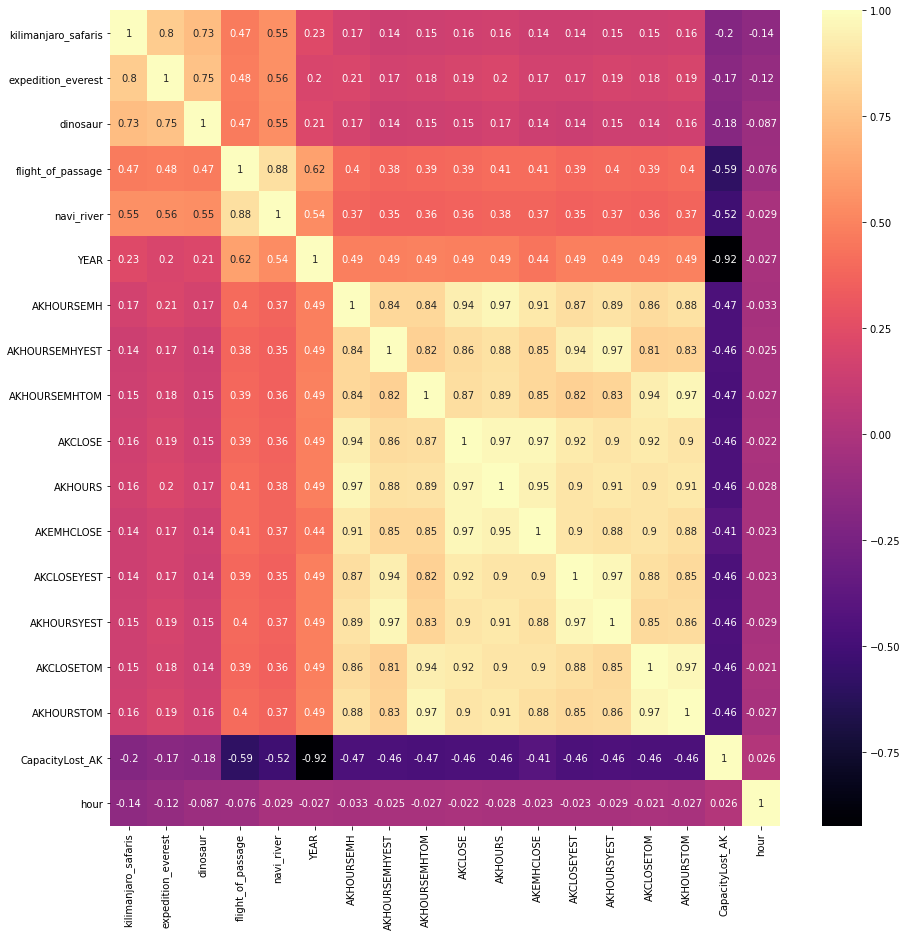

In [16]:
top_corr = mk.corr()
top_corr_features = top_corr.index[abs(top_corr["kilimanjaro_safaris"]) > .13]
plt.figure(figsize=(15,15))
g = sns.heatmap(mk[top_corr_features].corr(),annot=True,cmap="magma")

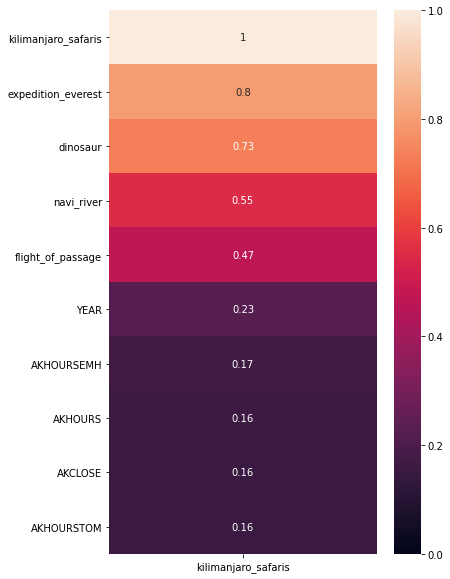

In [17]:
# One column heatmap for the Safaris
corr = mk.corr()
plt.figure(figsize = (6,10))
sns.heatmap(corr[['kilimanjaro_safaris']].sort_values(by = 'kilimanjaro_safaris', ascending = False).head(10),vmin = 0, annot = True)
plt.show()

In [18]:
# Set Features as columns to use for X variable, set y 
features = ['dinosaur','expedition_everest','flight_of_passage','navi_river', 'inSession', "AKCLOSE", 'AKOPEN',
            'YEAR', 'AKHOURS', 'DAYOFWEEK','HOLIDAYM',"MONTHOFYEAR",'DAYOFYEAR',
             'WDWSEASON_CHRISTMAS', 'WDWSEASON_CHRISTMAS PEAK', 
       'WDWSEASON_COLUMBUS DAY', 'WDWSEASON_EASTER', 'WDWSEASON_FALL',
       'WDWSEASON_HALLOWEEN', 'WDWSEASON_JERSEY WEEK', 'WDWSEASON_JULY 4TH',
       'WDWSEASON_MARDI GRAS', 'WDWSEASON_MARTIN LUTHER KING JUNIOR DAY',
       'WDWSEASON_MEMORIAL DAY', 'WDWSEASON_PRESIDENTS WEEK',
       'WDWSEASON_SEPTEMBER LOW', 'WDWSEASON_SPRING', 'WDWSEASON_SUMMER BREAK',
       'WDWSEASON_THANKSGIVING', 'WDWSEASON_WINTER',
            'hour','CapacityLostWGT_AK']
y = mk['kilimanjaro_safaris']
X = mk[features]

In [19]:
# Test train split, fit and transform the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.02, random_state=2020)
sc = StandardScaler()
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

# Linear Regression

In [20]:
# Created my model and started the train test split
linreg = LinearRegression()
linreg.fit(X_train_sc, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
# Predict on the training data
linreg_preds_train = linreg.predict(X_train_sc)
linreg_rms_train = sqrt(mean_squared_error(y_train, linreg_preds_train))
linreg_rms_train

16.133287512715764

In [22]:
# Score the testing data
linreg_preds_test = linreg.predict(X_test_sc)
linreg_rms_test = sqrt(mean_squared_error(y_test, linreg_preds_test))
linreg_rms_test

16.149833409373535

## KNN

In [23]:
# Instiantiated KNN and fitted the training
knn = KNeighborsRegressor()
knn.fit(X_train_sc, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [24]:
# Predict on the training data
knn_preds_train = knn.predict(X_train_sc)
knn_rms_train = sqrt(mean_squared_error(y_train, knn_preds_train))
knn_rms_train

10.773332947050616

In [25]:
# Score the testing data
knn_preds_test = knn.predict(X_test_sc)
knn_rms_test = sqrt(mean_squared_error(y_test, knn_preds_test))
knn_rms_test


15.14703246819629

## Decision Tree Model

In [26]:
# Instiantiate model and fit the Decision Tree
dt = DecisionTreeRegressor()
dt.fit(X_train_sc, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [27]:
# Predict on the training data
dt_preds_train = dt.predict(X_train_sc)
dt_rms_train = sqrt(mean_squared_error(y_train, dt_preds_train))
dt_rms_train

0.0

In [28]:
# Score the testing data
dt_preds_test = dt.predict(X_test_sc)
dt_rms_test = sqrt(mean_squared_error(y_test, dt_preds_test))
dt_rms_test

18.681326196772257

## Bagged Decision Tree

In [29]:
# Instiantiate model and fit the Bagged Decision Tree
bag = BaggingRegressor()
bag.fit(X_train_sc, y_train)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [30]:
# Predict on the training data
bag_preds_train = bag.predict(X_train_sc)
bag_rms_train = sqrt(mean_squared_error(y_train, bag_preds_train))
bag_rms_train

5.843192236741673

In [31]:
# Score the testing data
bag_preds_test = bag.predict(X_test_sc)
bag_rms_test = sqrt(mean_squared_error(y_test, bag_preds_test))
bag_rms_test

14.780244245877464

## Random Forests

In [32]:
# Instiantiate model and fit
rf = RandomForestRegressor()
rf.fit(X_train_sc, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [33]:
# Predict on the training data
rf_preds_train = rf.predict(X_train_sc)
rf_rms_train = sqrt(mean_squared_error(y_train, rf_preds_train))
rf_rms_train

4.866033061450454

In [34]:
# Score the testing data
rf_preds_test = rf.predict(X_test_sc)
rf_rms_test = sqrt(mean_squared_error(y_test, rf_preds_test))
rf_rms_test

13.25864849460086

## ADA boost

In [35]:
# Instiantiate model and fit
ada = AdaBoostRegressor()
ada.fit(X_train_sc, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)

In [36]:
# Predict on the training data
ada_preds_train = ada.predict(X_train_sc)
ada_rms_train = sqrt(mean_squared_error(y_train, ada_preds_train))
ada_rms_train

22.346496375112636

In [37]:
# Score the testing data
ada_preds_test = ada.predict(X_test_sc)
ada_rms_test = sqrt(mean_squared_error(y_test, ada_preds_test))
ada_rms_test

22.63933226843042

## SVM

In [38]:
# Instiantiate model and fit
svr = svm.SVR()
svr.fit(X_train_sc, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [39]:
# Predict on the training data
svr_preds_train = svr.predict(X_train_sc)
svr_rms_train = sqrt(mean_squared_error(y_train, svr_preds_train))
svr_rms_train

15.684987824154957

In [40]:
# Score the testing data
svr_preds_test = svr.predict(X_test_sc)
svr_rms_test = sqrt(mean_squared_error(y_test, svr_preds_test))
svr_rms_test

15.66344572261398

# XG Boost

In [41]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train_sc, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [42]:
# Predict RMSE on the training data
model_preds_train = model.predict(X_train_sc)
model_rms_train = sqrt(mean_squared_error(y_train, model_preds_train))
model_rms_train

17.064222726646463

In [43]:
# Score the testing data with RMSE
model_preds_test = model.predict(X_test_sc)
model_rms_test = sqrt(mean_squared_error(y_test, model_preds_test))
model_rms_test

17.717773130449928

# FBprophet

In [44]:
# Imported FBprophet at top of workbook
# Copied mk dataframe for use in FBprophet
df1 = mk[['kilimanjaro_safaris']].copy()
df1 = df1[~(df1.index < '2016-01-01')] 

In [45]:
# Made a 2 column dataframe in the format FBprophet requires (ds,'y')
df = df1
df.rename(columns = {'kilimanjaro_safaris':'y'}, inplace = True)
df.index.name = 'ds'
df = df.reset_index()
df['ds'] = pd.to_datetime(df["ds"])
print(df.info())
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24865 entries, 0 to 24864
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      24865 non-null  datetime64[ns]
 1   y       24865 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 388.6 KB
None


,ds,y
0,2016-01-01 00:00:00,0.0
1,2016-01-01 01:00:00,0.0


In [46]:
# Instiantiate the model ad m
m = Prophet()
m.add_country_holidays(country_name='US')
m.fit(df);

In [47]:
# Telling the number of periods in the future to predict, 3 months(18 hours * 90 days)
future = m.make_future_dataframe(periods=1620, freq='h')
forecast = m.predict(future)

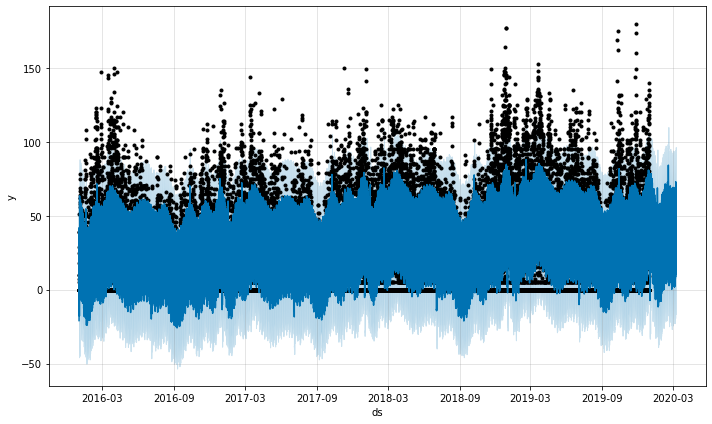

In [48]:
# Plot shows forcast line for 4 years and 3 month future prediction
fig1 = m.plot(forecast);

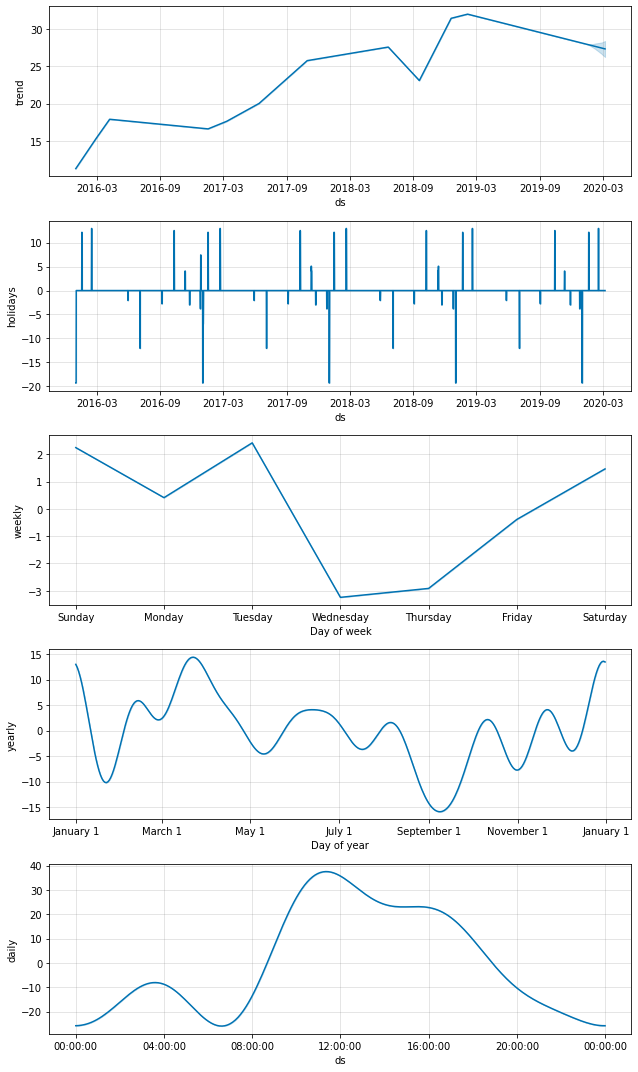

In [49]:
# Figures show trend and seasonality
fig2 = m.plot_components(forecast)

In [50]:
# # Interactive plot to view the podel predictions
# py.init_notebook_mode()
# fig = plot_plotly(m, forecast)  # This returns a plotly Figure
# py.iplot(fig)

In [51]:
# set initial training oc 1095 days and predictions of 30 days every 30 days
df_cv = cross_validation(m, initial='1095 days', period='30 days', horizon = '30 days')
df_cv

INFO:fbprophet:Making 12 forecasts with cutoffs between 2019-01-04 23:00:00 and 2019-11-30 23:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-01-05 06:00:00,25.239440,1.381865,48.429087,0.0,2019-01-04 23:00:00
1,2019-01-05 07:00:00,21.658588,-5.440312,46.655869,42.0,2019-01-04 23:00:00
2,2019-01-05 08:00:00,30.980859,5.079971,55.506238,62.0,2019-01-04 23:00:00
3,2019-01-05 09:00:00,50.292802,26.875045,76.931383,76.0,2019-01-04 23:00:00
4,2019-01-05 10:00:00,69.543238,45.353973,93.954579,113.0,2019-01-04 23:00:00
...,...,...,...,...,...,...
6250,2019-12-30 19:00:00,45.171741,19.636939,70.547827,0.0,2019-11-30 23:00:00
6251,2019-12-30 20:00:00,36.184981,11.636102,62.910961,0.0,2019-11-30 23:00:00
6252,2019-12-30 21:00:00,30.139701,5.705271,55.403766,0.0,2019-11-30 23:00:00
6253,2019-12-30 22:00:00,25.724264,1.885602,49.988670,0.0,2019-11-30 23:00:00


In [52]:
# Scoring the 30 day predictions on the model on several metrics
df_p = performance_metrics(df_cv)
df_p.tail()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
558,29 days 20:00:00,402.879957,20.071870,16.065258,0.471312,0.79240
559,29 days 21:00:00,404.988276,20.124321,16.090515,0.464347,0.79080
560,29 days 22:00:00,406.233644,20.155239,16.134611,0.471312,0.79168
561,29 days 23:00:00,407.268740,20.180900,16.165737,0.471312,0.78880
562,30 days 00:00:00,408.450145,20.210150,16.213167,0.471312,0.78880


In [53]:
# Viewing statistics on the models
df_p.describe()

,horizon,mse,rmse,mae,mdape,coverage
count,563,563.000000,563.000000,563.000000,563.000000,563.000000
mean,16 days 15:14:36.021314,471.197878,21.668636,17.007275,0.493060,0.776210
std,7 days 17:39:04.368512,56.941199,1.292703,0.852218,0.043983,0.021239
min,3 days 06:00:00,373.675860,19.330697,15.721681,0.419710,0.720800
25%,9 days 22:30:00,425.048424,20.616702,16.318199,0.458369,0.764067
50%,16 days 16:00:00,457.673850,21.393313,16.822820,0.482678,0.782400
75%,23 days 08:30:00,505.805712,22.490124,17.361362,0.527766,0.790400
max,30 days 00:00:00,608.679912,24.671439,18.871495,0.599918,0.817600


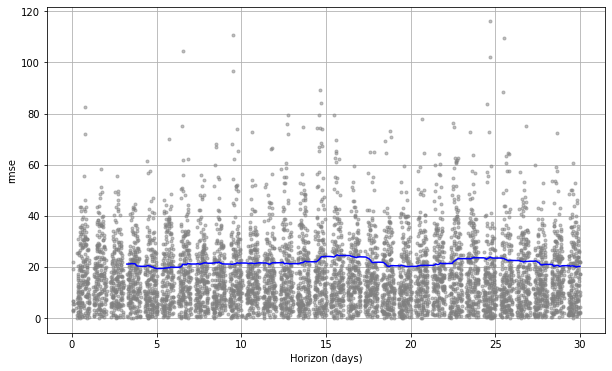

In [54]:
# plot showing the RMSE for the 30 day predictions
fig = plot_cross_validation_metric(df_cv, metric='rmse')